使用 ResNet-50 在 Imagenette 数据集上进行图像分类训练

## 📋 目录
1. [环境设置](#1-环境设置)
2. [加载数据集](#2-加载数据集)
3. [加载模型](#3-加载模型)
4. [数据预处理](#4-数据预处理)
5. [配置训练参数](#5-配置训练参数)
6. [开始训练](#6-开始训练)
7. [模型评估](#7-模型评估)
8. [结果可视化](#8-结果可视化)

---

## 1. 环境设置

### 1.1 导入必要的库

In [1]:
from datasets import load_from_disk
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import json
from datetime import datetime
from tqdm import tqdm

print("✅ 所有库导入成功!")

/root/miniconda3/envs/tmp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 所有库导入成功!


### 1.2 配置环境

In [2]:
# 本地资源路径
CACHE_DIR = "./cache"
DATASET_PATH = os.path.join(CACHE_DIR, "datasets", "imagenette")
MODEL_PATH = os.path.join(CACHE_DIR, "models", "resnet-50")
RESULTS_DIR = "./results"

# 创建结果目录
os.makedirs(RESULTS_DIR, exist_ok=True)

# 设置离线模式
os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"

# 设置绘图风格
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

# 启用 matplotlib 内联显示
%matplotlib inline

print("✅ 环境配置完成!")
print(f"📁 数据集路径: {DATASET_PATH}")
print(f"🤖 模型路径: {MODEL_PATH}")
print(f"💾 结果保存目录: {RESULTS_DIR}")

✅ 环境配置完成!
📁 数据集路径: ./cache/datasets/imagenette
🤖 模型路径: ./cache/models/resnet-50
💾 结果保存目录: ./results


### 1.3 辅助函数

In [3]:
def print_header(text):
    """打印美化的标题"""
    print("\n" + "=" * 70)
    print(f"  {text}")
    print("=" * 70)

def print_info(text, emoji="ℹ️"):
    """打印提示信息"""
    print(f"{emoji}  {text}")

def print_success(text):
    """打印成功信息"""
    print(f"✅ {text}")

def print_warning(text):
    """打印警告信息"""
    print(f"⚠️  {text}")

print("✅ 辅助函数定义完成!")

✅ 辅助函数定义完成!


---
## 2. 加载数据集

加载本地缓存的 Imagenette 数据集

In [5]:
print_header("📊 加载数据集")

# 检查数据集是否存在
if not os.path.exists(DATASET_PATH):
    print_warning("数据集未找到! 请先运行: python download_resources.py")
    raise FileNotFoundError(f"数据集不存在: {DATASET_PATH}")

# 加载数据集
dataset = load_from_disk(DATASET_PATH)

# 显示数据集信息
print_info("数据集结构:", "📦")
print(dataset)

# 统计信息
print("\n📈 数据集统计:")
for split in dataset.keys():
    print(f"  • {split:12s}: {len(dataset[split]):,} 样本")

print_success("数据集加载完成!")


  📊 加载数据集
📦  数据集结构:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9469
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3925
    })
})

📈 数据集统计:
  • train       : 9,469 样本
  • validation  : 3,925 样本
✅ 数据集加载完成!


### 2.1 查看样本示例

/tmp/ipykernel_10376/696827423.py:11: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/696827423.py:11: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/696827423.py:11: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/696827423.py:11: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/696827423.py:11: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/696827423.py:11: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/696827423.py:11: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  plt.tight_l

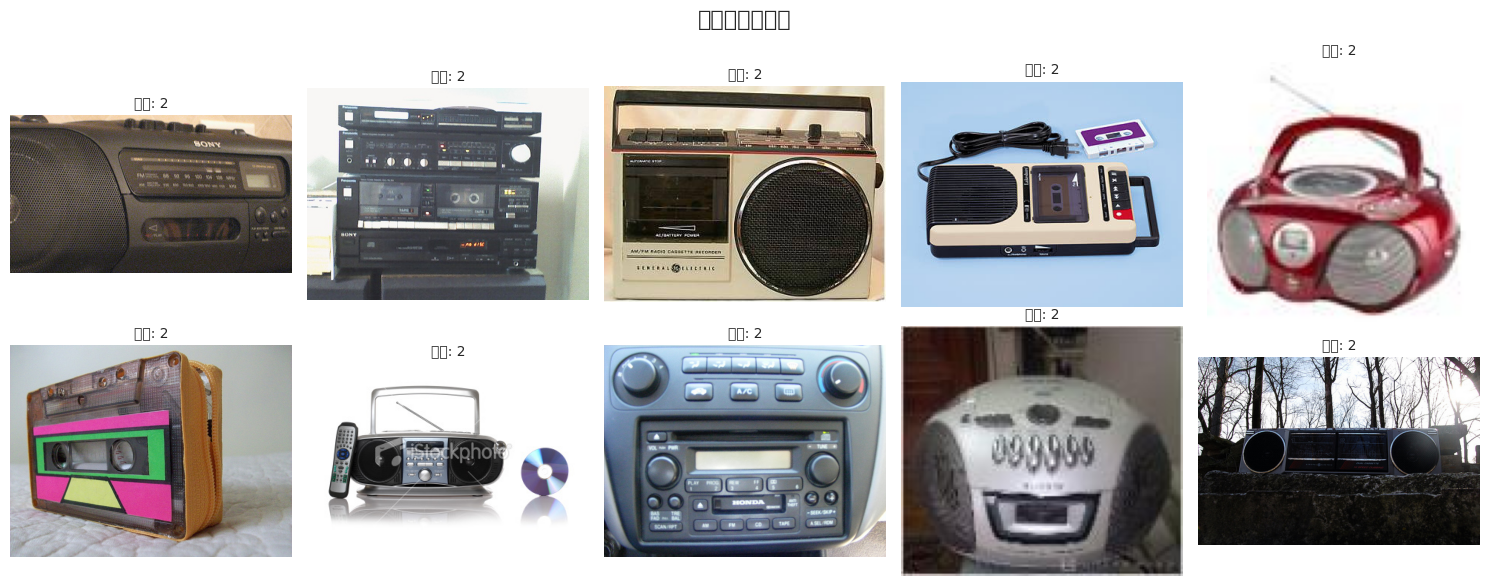

✅ 样本图像展示完成


In [6]:
# 显示几个样本图像
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('数据集样本示例', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    sample = dataset['train'][idx]
    ax.imshow(sample['image'])
    ax.set_title(f"类别: {sample['label']}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("✅ 样本图像展示完成")

---
## 3. 加载模型

加载预训练的 ResNet-50 模型和图像处理器

### 3.1 加载图像处理器

In [7]:
print_header("🤖 加载模型和处理器")

# 检查模型是否存在
if not os.path.exists(MODEL_PATH):
    print_warning("模型未找到! 请先运行: python download_resources.py")
    raise FileNotFoundError(f"模型不存在: {MODEL_PATH}")

# 加载图像处理器
print_info("正在加载图像处理器...", "⚙️")
image_processor = AutoImageProcessor.from_pretrained(MODEL_PATH, local_files_only=True)
print_success("图像处理器加载完成")


  🤖 加载模型和处理器
⚙️  正在加载图像处理器...
✅ 图像处理器加载完成


### 3.2 获取标签信息

In [8]:
# 获取标签信息
labels = dataset["train"].features["label"].names
num_labels = len(labels)

label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}

print_info(f"类别数量: {num_labels}", "🏷️")
print_info(f"类别列表:", "📝")
for i, label in enumerate(labels):
    print(f"  {i}: {label}")

🏷️  类别数量: 10
📝  类别列表:
  0: tench
  1: English springer
  2: cassette player
  3: chain saw
  4: church
  5: French horn
  6: garbage truck
  7: gas pump
  8: golf ball
  9: parachute


### 3.3 加载预训练模型

In [9]:
print_info("正在加载预训练模型 ResNet-50...", "🧠")

model = AutoModelForImageClassification.from_pretrained(
    MODEL_PATH,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    local_files_only=True,
)

# 统计模型参数
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print_info(f"模型总参数: {total_params:,}", "📊")
print_info(f"可训练参数: {trainable_params:,}", "🎯")
print_success("模型加载完成!")

🧠  正在加载预训练模型 ResNet-50...


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at ./cache/models/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([10, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊  模型总参数: 23,528,522
🎯  可训练参数: 23,528,522
✅ 模型加载完成!


---
## 4. 数据预处理

对图像进行预处理(调整大小、归一化等)

In [10]:
print_header("🎨 数据预处理")

def preprocess_function(examples):
    """数据预处理函数"""
    images = [img.convert("RGB") for img in examples["image"]]
    inputs = image_processor(images)
    inputs["labels"] = examples["label"]
    return inputs

# 预处理数据集
prepared_ds = {}
for split in dataset.keys():
    print_info(f"处理 {split} 集...", "⚙️")
    prepared_ds[split] = dataset[split].map(
        preprocess_function,
        batched=True,
        remove_columns=["image"],
        desc=f"预处理 {split} 集"
    )
    prepared_ds[split].set_format("torch")
    print_success(f"{split} 集预处理完成 ({len(prepared_ds[split])} 样本)")

print_success("所有数据预处理完成!")


  🎨 数据预处理
⚙️  处理 train 集...


预处理 train 集: 100%|██████████| 9469/9469 [02:08<00:00, 73.88 examples/s]


✅ train 集预处理完成 (9469 样本)
⚙️  处理 validation 集...


预处理 validation 集: 100%|██████████| 3925/3925 [00:51<00:00, 76.31 examples/s]

✅ validation 集预处理完成 (3925 样本)
✅ 所有数据预处理完成!


---
## 5. 配置训练参数

设置训练配置(批次大小、学习率、轮数等)

In [ ]:
print_header("⚙️ 配置训练参数")

# 训练配置 - 可以根据需要调整
train_batch_size = 32
eval_batch_size = 32
num_epochs = 5
learning_rate = 5e-5

print_info(f"批次大小 (训练): {train_batch_size}", "📦")
print_info(f"批次大小 (评估): {eval_batch_size}", "📦")
print_info(f"训练轮数: {num_epochs}", "🔄")
print_info(f"学习率: {learning_rate}", "📈")

# 计算训练步数
total_steps = (len(prepared_ds["train"]) // train_batch_size) * num_epochs
print_info(f"预计训练步数: {total_steps:,}", "⏱️")

# 定义评估指标
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

# 创建训练参数
training_args = TrainingArguments(
    output_dir="./resnet50-imagenette",
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    num_train_epochs=num_epochs,
    learning_rate=learning_rate,
    evaluation_strategy="no",  # 训练过程中不进行验证
    save_strategy="epoch",
    logging_steps=50,
    remove_unused_columns=False,
    logging_dir=os.path.join(RESULTS_DIR, "logs"),
    report_to="none",
)

print_success("训练参数配置完成!")


  ⚙️ 配置训练参数
📦  批次大小 (训练): 32
📦  批次大小 (评估): 32
🔄  训练轮数: 5
📈  学习率: 5e-05
⏱️  预计训练步数: 1,475
✅ 训练参数配置完成!


---
## 6. 开始训练

初始化 Trainer 并开始训练模型

> ⚠️ **注意**: 训练可能需要较长时间(取决于硬件配置)

In [ ]:
print_header("🚀 开始训练")

# 初始化 Trainer（
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_ds["train"],
    compute_metrics=compute_metrics,
)

print_success("Trainer 初始化完成")

# 记录开始时间
start_time = datetime.now()
print_info(f"训练开始时间: {start_time.strftime('%Y-%m-%d %H:%M:%S')}", "⏰")

# 开始训练
train_result = trainer.train()

# 记录结束时间
end_time = datetime.now()
training_duration = end_time - start_time
print_success(f"训练完成! 用时: {training_duration}")

# 显示训练指标
train_metrics = train_result.metrics
print("\n📊 训练指标:")
for key, value in train_metrics.items():
    if isinstance(value, float):
        print(f"  • {key}: {value:.4f}")
    else:
        print(f"  • {key}: {value}")


  🚀 开始训练
✅ Trainer 初始化完成
⏰  训练开始时间: 2025-11-11 19:09:11


/root/miniconda3/envs/tmp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.270800,0.797473,0.969936
2,0.265600,0.144616,0.984459
3,0.146400,0.083811,0.985987
4,0.105900,0.069078,0.988025
5,0.096600,0.066115,0.990828


✅ 训练完成! 用时: 0:13:35.906598

📊 训练指标:
  • train_runtime: 815.7451
  • train_samples_per_second: 58.0390
  • train_steps_per_second: 1.8140
  • total_flos: 1006091105226117120.0000
  • train_loss: 0.4910
  • epoch: 5.0000


---
## 7. 模型评估

在验证集和测试集上评估模型性能

In [ ]:
print_header("📋 模型评估")

# 在验证集上评估
print_info("在验证集上评估...", "🔍")
eval_results = trainer.evaluate(prepared_ds.get("validation", prepared_ds["train"]))

print("\n📊 验证集指标:")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"  • {key}: {value:.4f}")
    else:
        print(f"  • {key}: {value}")

print_success("评估完成!")


  📋 模型评估
🔍  在验证集上评估...



📊 验证集指标:
  • eval_loss: 0.0661
  • eval_accuracy: 0.9908
  • eval_runtime: 41.6407
  • eval_samples_per_second: 94.2590
  • eval_steps_per_second: 2.9540
  • epoch: 5.0000
✅ 评估完成!


### 7.1 生成预测结果

In [15]:
# 生成预测用于可视化
print_info("生成预测结果...", "🎯")

eval_dataset = prepared_ds.get("validation", prepared_ds["train"])
predictions = trainer.predict(eval_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

print_success(f"预测完成! 共 {len(pred_labels)} 个样本")

🎯  生成预测结果...
✅ 预测完成! 共 3925 个样本


---
## 8. 结果可视化

生成多维度的可视化图表

### 8.1 混淆矩阵

/root/miniconda3/envs/tmp/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  fig.canvas.draw()
/root/miniconda3/envs/tmp/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.canvas.draw()
/root/miniconda3/envs/tmp/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.draw()
/root/miniconda3/envs/tmp/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_10376/1041106306.py:13: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/1041106306.py:13: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.t

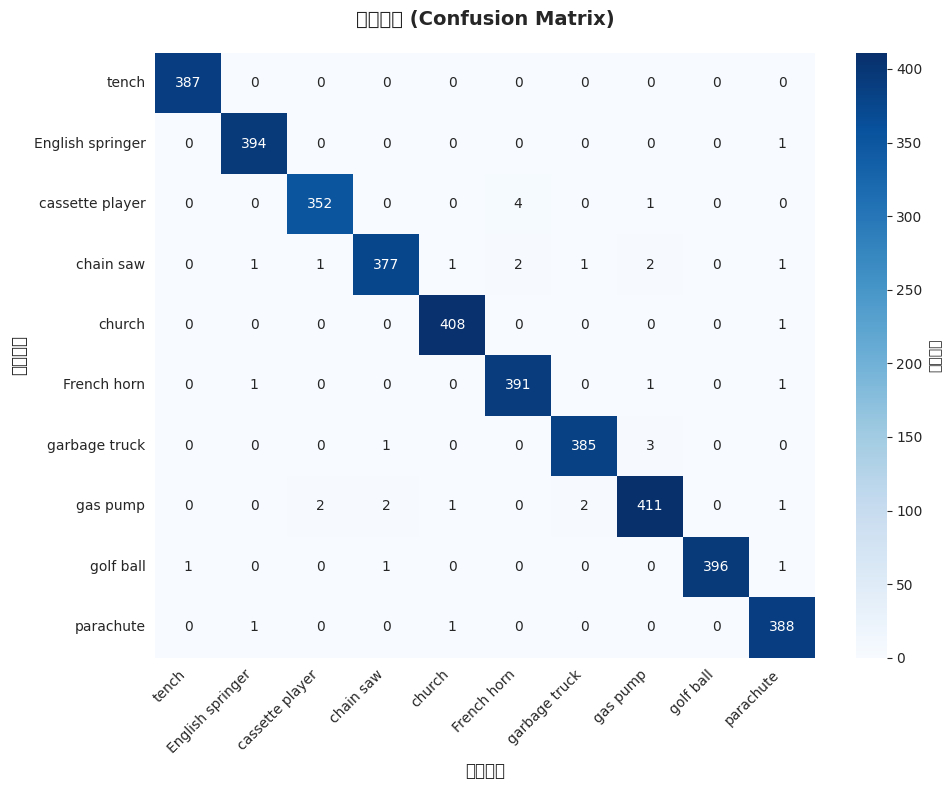

✅ 混淆矩阵绘制完成


In [16]:
# 混淆矩阵
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': '样本数量'})
plt.title('混淆矩阵 (Confusion Matrix)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('预测类别', fontsize=12)
plt.ylabel('真实类别', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ 混淆矩阵绘制完成")

### 8.2 各类别准确率

/tmp/ipykernel_10376/3080355108.py:22: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/3080355108.py:22: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/3080355108.py:22: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/3080355108.py:22: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/3080355108.py:22: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/3080355108.py:22: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/root/miniconda3/envs/tmp/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20934 (\N{CJK UNIFIED ID

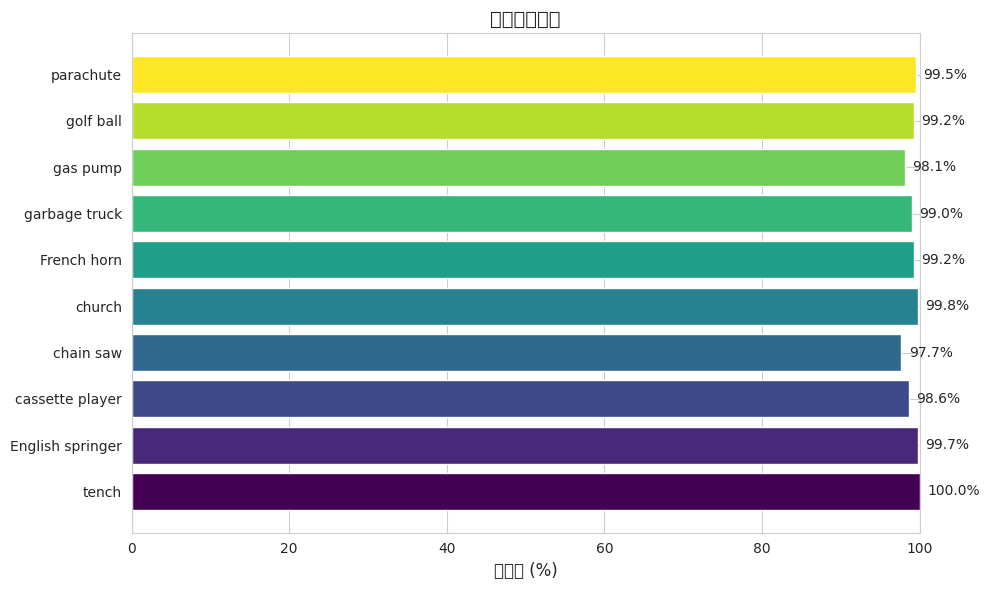

✅ 类别准确率图表绘制完成


In [17]:
# 计算每个类别的准确率
class_accuracy = []
for i in range(len(labels)):
    mask = true_labels == i
    if mask.sum() > 0:
        acc = (pred_labels[mask] == true_labels[mask]).mean()
        class_accuracy.append(acc * 100)
    else:
        class_accuracy.append(0)

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
bars = plt.barh(labels, class_accuracy, color=colors)
plt.xlabel('准确率 (%)', fontsize=12)
plt.title('各类别准确率', fontsize=14, fontweight='bold')
plt.xlim(0, 100)

# 添加数值标签
for i, (bar, acc) in enumerate(zip(bars, class_accuracy)):
    plt.text(acc + 1, i, f'{acc:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("✅ 类别准确率图表绘制完成")

### 8.3 整体性能指标

/tmp/ipykernel_10376/1939004247.py:24: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/1939004247.py:24: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/1939004247.py:24: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/1939004247.py:24: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/1939004247.py:24: UserWarning: Glyph 21484 (\N{CJK UNIFIED IDEOGRAPH-53EC}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/1939004247.py:24: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/1939004247.py:24: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.

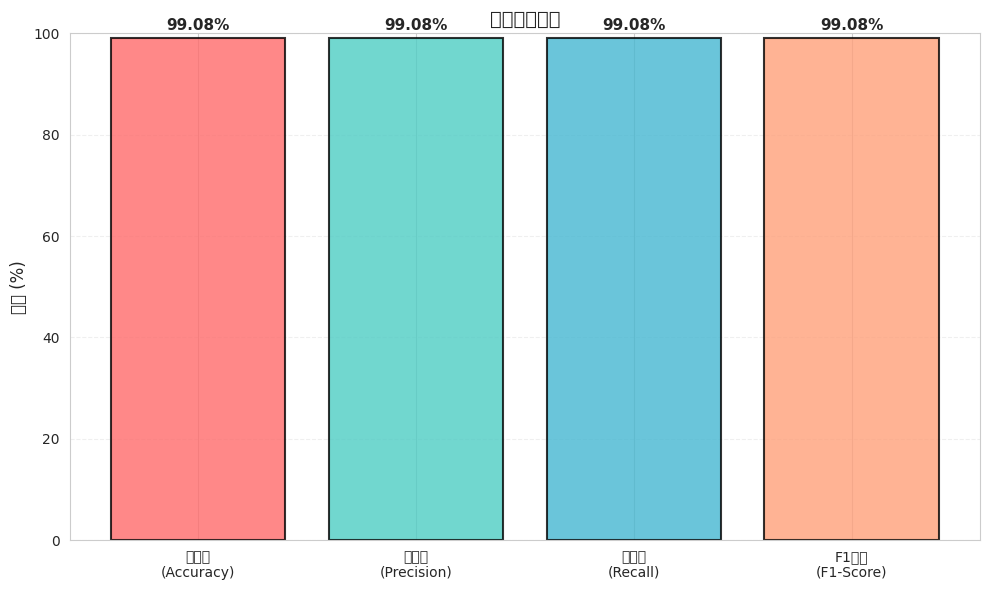

✅ 性能指标图表绘制完成


In [18]:
# 计算各项指标
precision = precision_score(true_labels, pred_labels, average='weighted') * 100
recall = recall_score(true_labels, pred_labels, average='weighted') * 100
f1 = f1_score(true_labels, pred_labels, average='weighted') * 100
accuracy = eval_results['eval_accuracy'] * 100

metrics = ['准确率\n(Accuracy)', '精确率\n(Precision)', '召回率\n(Recall)', 'F1分数\n(F1-Score)']
values = [accuracy, precision, recall, f1]
colors_metrics = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.ylabel('分数 (%)', fontsize=12)
plt.title('整体性能指标', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# 添加数值标签
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ 性能指标图表绘制完成")

### 8.4 真实 vs 预测分布

/tmp/ipykernel_10376/168452406.py:18: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/168452406.py:18: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/168452406.py:18: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/168452406.py:18: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/168452406.py:18: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/168452406.py:18: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/168452406.py:18: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.tight_l

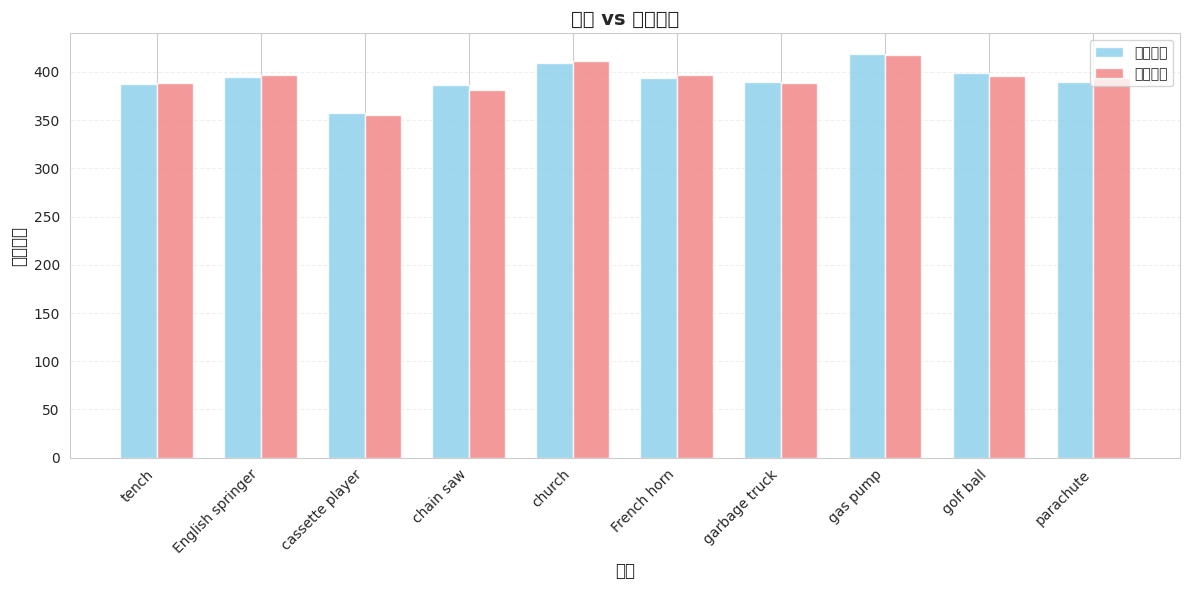

✅ 分布对比图表绘制完成


In [19]:
# 统计分布
true_counts = np.bincount(true_labels, minlength=len(labels))
pred_counts = np.bincount(pred_labels, minlength=len(labels))

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, true_counts, width, label='真实分布', color='skyblue', alpha=0.8)
plt.bar(x + width/2, pred_counts, width, label='预测分布', color='lightcoral', alpha=0.8)

plt.xlabel('类别', fontsize=12)
plt.ylabel('样本数量', fontsize=12)
plt.title('真实 vs 预测分布', fontsize=14, fontweight='bold')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("✅ 分布对比图表绘制完成")

### 8.5 详细分类报告

In [20]:
# 生成分类报告
print("\n" + "=" * 70)
print("详细分类报告")
print("=" * 70)
report = classification_report(true_labels, pred_labels, target_names=labels, digits=4)
print(report)
print("=" * 70)

print(f"\n📊 整体准确率: {accuracy:.2f}%")
print(f"📊 加权精确率: {precision:.2f}%")
print(f"📊 加权召回率: {recall:.2f}%")
print(f"📊 加权F1分数: {f1:.2f}%")


详细分类报告
                  precision    recall  f1-score   support

           tench     0.9974    1.0000    0.9987       387
English springer     0.9924    0.9975    0.9949       395
 cassette player     0.9915    0.9860    0.9888       357
       chain saw     0.9895    0.9767    0.9831       386
          church     0.9927    0.9976    0.9951       409
     French horn     0.9849    0.9924    0.9886       394
   garbage truck     0.9923    0.9897    0.9910       389
        gas pump     0.9833    0.9809    0.9821       419
       golf ball     1.0000    0.9925    0.9962       399
       parachute     0.9848    0.9949    0.9898       390

        accuracy                         0.9908      3925
       macro avg     0.9909    0.9908    0.9908      3925
    weighted avg     0.9908    0.9908    0.9908      3925


📊 整体准确率: 99.08%
📊 加权精确率: 99.08%
📊 加权召回率: 99.08%
📊 加权F1分数: 99.08%


### 8.6 保存完整可视化图表

/root/miniconda3/envs/tmp/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  fig.canvas.draw()
/root/miniconda3/envs/tmp/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.canvas.draw()
/root/miniconda3/envs/tmp/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.draw()
/root/miniconda3/envs/tmp/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_10376/1252353486.py:46: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10376/1252353486.py:46: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.t

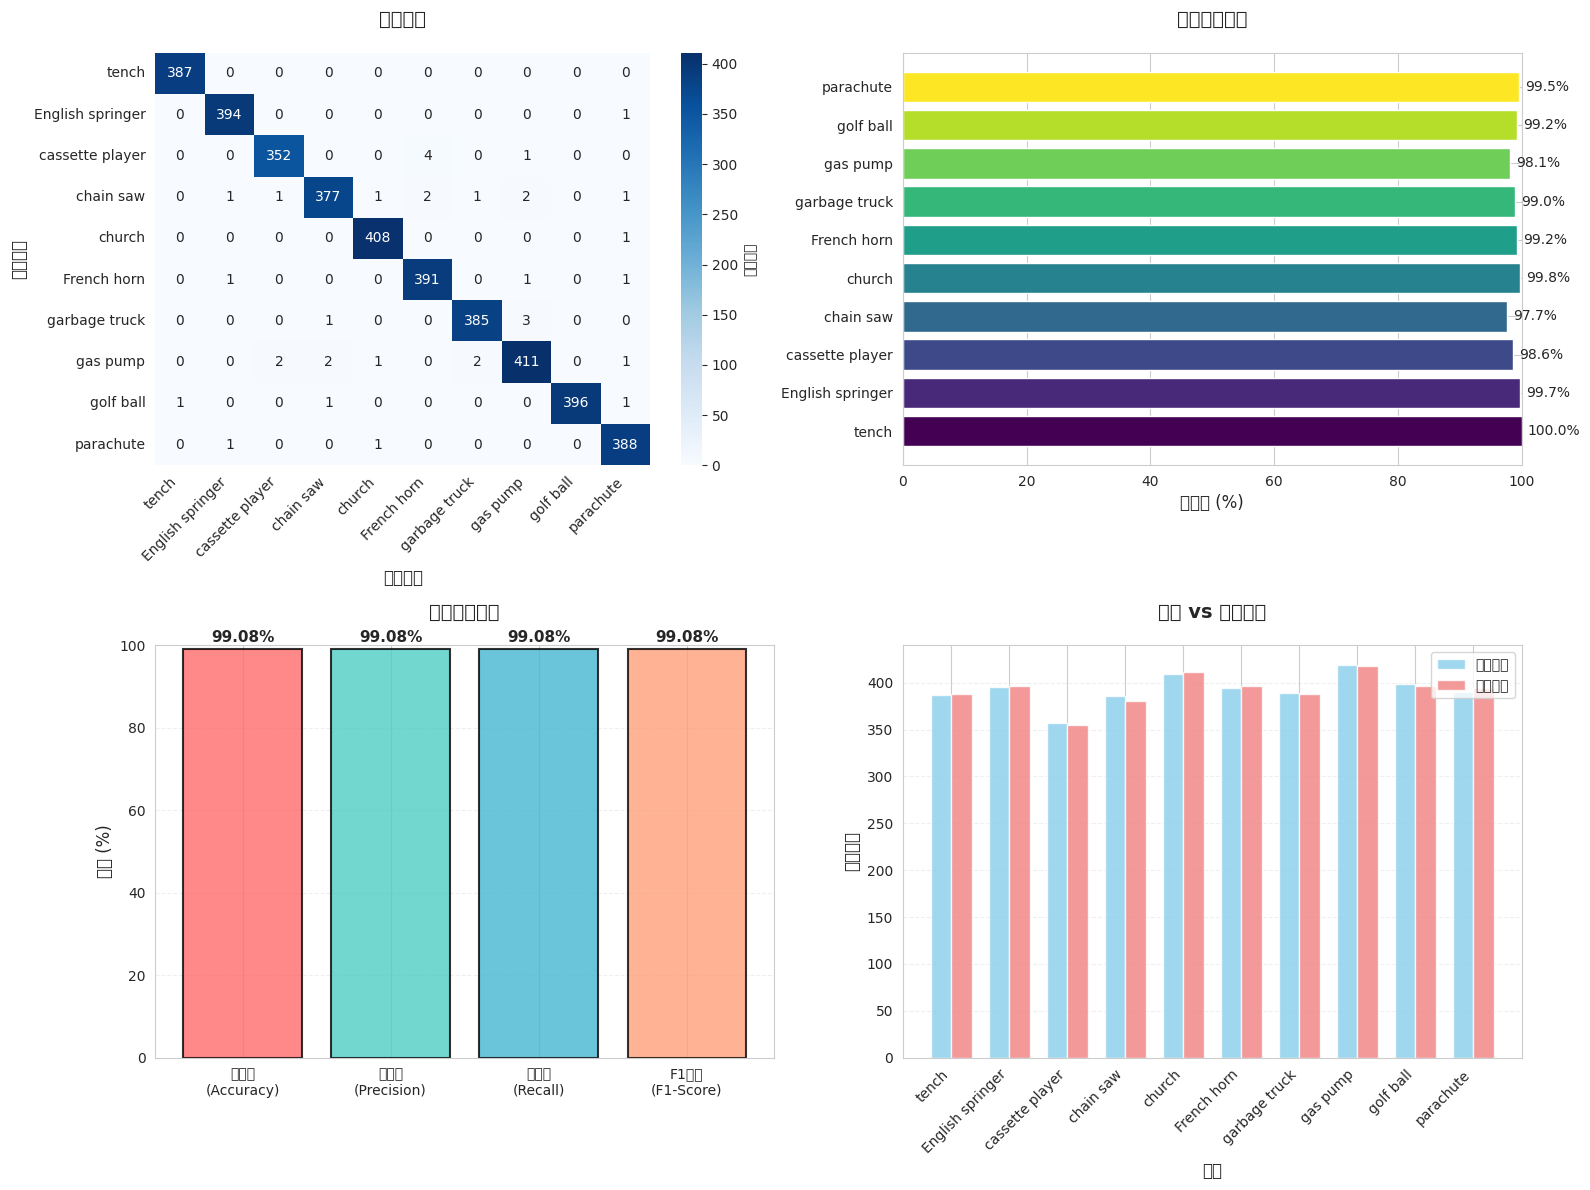

✅ 综合图表已保存到: ./results/evaluation_results.png


In [21]:
# 创建 2x2 综合图表
fig = plt.figure(figsize=(16, 12))

# 1. 混淆矩阵
ax1 = plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': '样本数量'})
plt.title('混淆矩阵', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('预测类别', fontsize=12)
plt.ylabel('真实类别', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 2. 各类别准确率
ax2 = plt.subplot(2, 2, 2)
bars = plt.barh(labels, class_accuracy, color=plt.cm.viridis(np.linspace(0, 1, len(labels))))
plt.xlabel('准确率 (%)', fontsize=12)
plt.title('各类别准确率', fontsize=14, fontweight='bold', pad=20)
plt.xlim(0, 100)
for i, (bar, acc) in enumerate(zip(bars, class_accuracy)):
    plt.text(acc + 1, i, f'{acc:.1f}%', va='center', fontsize=10)

# 3. 性能指标
ax3 = plt.subplot(2, 2, 3)
bars = plt.bar(metrics, values, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.ylabel('分数 (%)', fontsize=12)
plt.title('整体性能指标', fontsize=14, fontweight='bold', pad=20)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. 分布对比
ax4 = plt.subplot(2, 2, 4)
plt.bar(x - width/2, true_counts, width, label='真实分布', color='skyblue', alpha=0.8)
plt.bar(x + width/2, pred_counts, width, label='预测分布', color='lightcoral', alpha=0.8)
plt.xlabel('类别', fontsize=12)
plt.ylabel('样本数量', fontsize=12)
plt.title('真实 vs 预测分布', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# 保存图表
plot_file = os.path.join(RESULTS_DIR, 'evaluation_results.png')
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
plt.show()

print_success(f"综合图表已保存到: {plot_file}")

### 8.7 保存结果到文件

In [22]:
# 保存 JSON 结果
results_summary = {
    "training_duration": str(training_duration),
    "start_time": start_time.strftime('%Y-%m-%d %H:%M:%S'),
    "end_time": end_time.strftime('%Y-%m-%d %H:%M:%S'),
    "train_metrics": {k: float(v) if isinstance(v, (int, float, np.number)) else str(v) 
                     for k, v in train_metrics.items()},
    "validation_metrics": {k: float(v) if isinstance(v, (int, float, np.number)) else str(v) 
                          for k, v in eval_results.items()},
    "test_metrics": {k: float(v) if isinstance(v, (int, float, np.number)) else str(v) 
                    for k, v in test_results.items()} if test_results else None,
    "num_labels": num_labels,
    "labels": labels,
}

results_file = os.path.join(RESULTS_DIR, "training_results.json")
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print_success(f"JSON 结果已保存到: {results_file}")

# 保存分类报告
report_file = os.path.join(RESULTS_DIR, 'classification_report.txt')
with open(report_file, 'w', encoding='utf-8') as f:
    f.write("图像分类详细报告\n")
    f.write("=" * 70 + "\n\n")
    f.write(report)
    f.write("\n\n" + "=" * 70 + "\n")
    f.write(f"整体准确率: {accuracy:.2f}%\n")
    f.write(f"加权精确率: {precision:.2f}%\n")
    f.write(f"加权召回率: {recall:.2f}%\n")
    f.write(f"加权F1分数: {f1:.2f}%\n")

print_success(f"分类报告已保存到: {report_file}")
print_info(f"所有结果保存在: {os.path.abspath(RESULTS_DIR)}", "📁")

✅ JSON 结果已保存到: ./results/training_results.json
✅ 分类报告已保存到: ./results/classification_report.txt
📁  所有结果保存在: /root/autodl-tmp/image_classification/results


---
## 🎉 训练完成!

### 📊 结果总结

- ✅ 训练完成
- ✅ 模型评估完成
- ✅ 可视化图表生成
- ✅ 结果文件保存

### 📁 输出文件

所有结果保存在 `results/` 目录:
- `evaluation_results.png` - 综合可视化图表
- `classification_report.txt` - 详细分类报告
- `training_results.json` - JSON 格式结果

### 🚀 下一步

- 尝试调整超参数提升性能
- 使用更大的数据集
- 尝试其他预训练模型
- 部署模型进行推理